### Code to aggregate NASA HiMAT WBM data to GRACE mascons

The WBM model results are preliminary and unpublished.
For permission to use these data in publications, you must contact a member of the UNH WBM team:
* Richard Lammers (Richard.lammers@unh.edu)
* Danielle Grogan (Danielle.Grogan@unh.edu)
* Alex Prusevich (alex.prusevich@unh.edu)

In [5]:
# Jupter notebook magic
%matplotlib inline

# Import libraries to work with the data

import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import xarray as xr
import boto3
import botocore
from dask.diagnostics import ProgressBar
import urllib.request
    
matplotlib.style.use('ggplot')

from himatpy.GRACE_MASCON.pygrace import (extract_grace, get_mascon_gdf, trend_analysis, get_cmwe_trend_analysis, select_mascons, aggregate_mascons)

import warnings
warnings.filterwarnings('ignore')

### Open the test dataset (linked to a local drive temporarily)

In [ ]:
datadir = '/mnt/c/work/datadrive/WBM/total_mass/'

In [3]:
ds = xr.open_mfdataset(datadir + '*.nc')

### Download the GRACE data from S3 bucket
The file is open to the public so we can use urllib

In [2]:
fileName = '../../files/GRACE/GSFC.glb.200301_201607_v02.4-ICE6G.h5'
urllib.request.urlretrieve ('https://himat-data.s3.us-west-2.amazonaws.com/GRACE/GSFC.glb.200301_201607_v02.4-ICE6G.h5', fileName)

('../../files/GRACE/GSFC.glb.200301_201607_v02.4-ICE6G.h5',
 <http.client.HTTPMessage at 0x7fedec383438>)

### Read in the GRACE data

In [6]:
grace_file = os.path.abspath(fileName)
f = extract_grace(grace_file)

Data extracted: 
---
Group: mascon
---
<HDF5 dataset "area_deg": shape (1, 41168), type "<f8">
<HDF5 dataset "area_km2": shape (1, 41168), type "<f8">
<HDF5 dataset "basin": shape (1, 41168), type "<f8">
<HDF5 dataset "elev_flag": shape (1, 41168), type "<f8">
<HDF5 dataset "lat_center": shape (1, 41168), type "<f8">
<HDF5 dataset "lat_span": shape (1, 41168), type "<f8">
<HDF5 dataset "location": shape (1, 41168), type "<f8">
<HDF5 dataset "lon_center": shape (1, 41168), type "<f8">
<HDF5 dataset "lon_span": shape (1, 41168), type "<f8">
---
Group: size
---
<HDF5 dataset "N_arcs": shape (1, 1), type "<f8">
<HDF5 dataset "N_mascon_times": shape (1, 1), type "<f8">
<HDF5 dataset "N_mascons": shape (1, 1), type "<f8">
---
Group: solution
---
<HDF5 dataset "cmwe": shape (41168, 148), type "<f8">
---
Group: time
---
<HDF5 dataset "list_ref_days_solution": shape (1, 4128), type "<f8">
<HDF5 dataset "n_ref_days_solution": shape (1, 148), type "<f8">
<HDF5 dataset "n_ref_days_window": shape (

In [9]:
mascon = f['mascon']
soln = f['solution']
time = f['time']

mascon_gdf = get_mascon_gdf(mascon)
## we need to track mascon numbers later, which we get from the index, so make a new "mascon" column
mascon_gdf['mascon'] = mascon_gdf.index

There are 41168 Mascons in this dataset.


### Tidy up the variable names to comply with our function (TODO: need to generalize this); quick fix to clip values to handle values associated with endoheric basins

In [ ]:
ds = ds.rename({'lon':'long'}).drop('crs')
ds = ds.where(ds['total_mass'].values < 5000, np.nan)

### Clip the GRACE mascons to the domain of the model output

In [12]:
masked_gdf = select_mascons(ds, mascon_gdf)

### The main processing step that calculates a mean value across each mascon

In [13]:
with ProgressBar():
    agg_data = aggregate_mascons(ds, masked_gdf, scale_factor = 1)

[########################################] | 100% Completed |  4min  2.6s


### Convert array to Pandas dataframe for plotting

In [14]:
A = agg_data['data']

names = ['products', 'mascons', 'time']
index = pd.MultiIndex.from_product([agg_data[n] for n in names], names=names)
df = pd.DataFrame({'A': A.flatten()}, index=index)['A']
df = df.unstack(level='products').swaplevel().sort_index()
df.columns = agg_data['products']
df.index.names = ['date','mascon']

### Sample plot for a single mascon

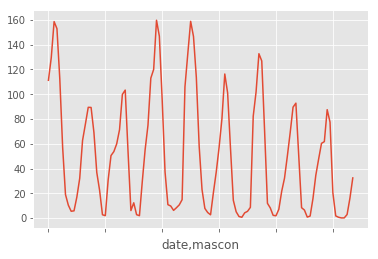

In [16]:
df['total_mass'].iloc[df.index.get_level_values('mascon') == 5795].plot()